In [65]:
# python imports
from transformers import BertModel, BertTokenizer, AdamWeightDecay, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from textwrap import wrap

# MLflow imports
import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import os
import hashlib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

In [66]:
# CONFIGURACIÓN DE MLFLOW 

# Configurar MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Cambia por tu servidor MLflow si tienes uno
experiment_name = "BERT_Text_Classification_Experiment"

# Crear o usar experimento existente
try:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    print(f"Usando experimento existente: {experiment_name}")
except:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Experimento creado: {experiment_name}")

mlflow.set_experiment(experiment_name)

# Habilitar autologging para PyTorch y sklearn
mlflow.pytorch.autolog(log_models=True, log_every_n_epoch=1, log_every_n_step=None)
mlflow.sklearn.autolog()

print(f"MLflow configurado. Experimento ID: {experiment_id}")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

# Función para calcular hash del dataset
def calculate_data_hash(df):
    """Calcula un hash único del dataset para tracking de versiones"""
    data_string = df.to_string()
    return hashlib.md5(data_string.encode()).hexdigest()

# Función para obtener información del código
def get_code_version():
    """Obtiene información sobre la versión del código"""
    import sys
    return {
        "python_version": sys.version,
        "torch_version": torch.__version__,
        "transformers_version": None,  # Se actualizará después de importar transformers
        "timestamp": datetime.now().isoformat()
    }

Usando experimento existente: BERT_Text_Classification_Experiment
MLflow configurado. Experimento ID: 1
Tracking URI: http://127.0.0.1:5000


In [67]:
# INICIALIZACIÓN Y CONFIGURACIÓN DE HIPERPARÁMETROS 

# Configuración base
RANDOM_SEED = 42
MAX_LEN = 500
BATCH_SIZE = 24
DATASET_PATH = "historias_clinicas_procesadas.xlsx"
NCLASS = 6

# Hiperparámetros configurables para optimización
HYPERPARAMS = {
    'learning_rate': 2e-5,
    'epochs': 10,
    'dropout_rate': 0.3,
    'batch_size': BATCH_SIZE,
    'max_length': MAX_LEN,
    'warmup_steps': 0,
    'weight_decay': 0.01,
    'max_grad_norm': 1.0,
    'sample_size': 5000,  # Para experimentación rápida
}

# Configuración del modelo
MODEL_CONFIG = {
    'pre_trained_model': 'bert-base-multilingual-cased',
    'n_classes': NCLASS,
    'random_seed': RANDOM_SEED,
}

# Configuración de datos
DATA_CONFIG = {
    'dataset_path': DATASET_PATH,
    'test_size': 0.2
}

# Semillas para reproducibilidad
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mostrar configuración
print("\n====== CONFIGURACIÓN DEL EXPERIMENTO ======")
print("Hiperparámetros:")
for key, value in HYPERPARAMS.items():
    print(f"  {key}: {value}")
    
print("\nConfiguración del modelo:")
for key, value in MODEL_CONFIG.items():
    print(f"  {key}: {value}")
    
print("\nConfiguración de datos:")
for key, value in DATA_CONFIG.items():
    print(f"  {key}: {value}")

Using device: cuda:0

====== CONFIGURACIÓN DEL EXPERIMENTO ======
Hiperparámetros:
  learning_rate: 2e-05
  epochs: 10
  dropout_rate: 0.3
  batch_size: 24
  max_length: 500
  warmup_steps: 0
  weight_decay: 0.01
  max_grad_norm: 1.0
  sample_size: 5000

Configuración del modelo:
  pre_trained_model: bert-base-multilingual-cased
  n_classes: 6
  random_seed: 42

Configuración de datos:
  dataset_path: historias_clinicas_procesadas.xlsx
  test_size: 0.2


In [70]:
print("CUDA disponible:", torch.cuda.is_available())
print("Versión compilada con PyTorch:", torch.version.cuda)
print("Versión de cuDNN:", torch.backends.cudnn.version())
print("Nombre de GPU:", torch.cuda.get_device_name(0))

CUDA disponible: True
Versión compilada con PyTorch: 12.8
Versión de cuDNN: 91002
Nombre de GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [71]:
# CARGA Y PROCESAMIENTO DE DATOS 

# Cargar dataset
print("Cargando dataset...")
df = pd.read_excel(DATASET_PATH)
print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")

# Calcular hash del dataset original para tracking
original_data_hash = calculate_data_hash(df)
print(f"Hash del dataset original: {original_data_hash}")

df.head()

Cargando dataset...
Dataset cargado: 9809 registros, 9 columnas
Hash del dataset original: 05deb52767a543339ba651baf113e3e6


,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
0,Femenino,38,Otros trastornos,PSICOLOGÍA,"Paciente refiere: ""Me empezaron a dar como uno...","Paciente alerta, colaboradora con apariencia o...","['empezar', 'episodio', 'tom', 'pastilla', 'do...",0,0
1,Masculino,22,T. externalizantes,PSICOLOGÍA,"Paciente refiere ""Me he sentido muy mal, en el...","Paciente a quien evaluó por primera vez, alert...","['sentido', 'trabajar', 'concentrar yo', 'cosa...",1,4
2,Masculino,9,Otros trastornos,PSICOLOGÍA,"La madre refiere ""el viene por un acompañamien...",NaN,"['madre', 'venir', 'acompañamiento', 'emociona...",1,0
3,Masculino,28,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""Estas cosas que han pasado m...","Paciente quien evalúo por primera vez, alerta,...","['cosa', 'problema', 'empresa', 'ocasión', 'sa...",1,0
4,Femenino,8,Otros trastornos,PSICOLOGÍA,"La madre refiere ""Ella ha manifestado ciertas ...","Paciente ingresa en compañía de la madre, aler...","['madre', 'manifestar', 'conducta', 'palabrase...",0,0


In [72]:
# Muestreo de datos para experimentación
sample_size = HYPERPARAMS['sample_size']
df = df.sample(n=sample_size, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Usando muestra de {sample_size} registros para experimentación")

# Calcular hash del dataset procesado
processed_data_hash = calculate_data_hash(df)
print(f"Hash del dataset procesado: {processed_data_hash}")

# Información del dataset para MLflow
dataset_info = {
    'original_size': None,  # Se actualizará con el tamaño original
    'sample_size': len(df),
    'features': list(df.columns),
    'target_column': 'grupo_codificado',
    'n_classes': NCLASS,
    'original_hash': original_data_hash,
    'processed_hash': processed_data_hash
}

Usando muestra de 5000 registros para experimentación
Hash del dataset procesado: bab15416c50bc9dc09e2b48681cca820


In [73]:
df.head()

,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
0,Masculino,16,T. de adaptación,PSICOLOGÍA,SEGUIMIENTO: La paciente refiere altibajos emo...,"Paciente orientada en tiempo, lugar y persona,...","['seguimiento', 'altibajo', 'emocional', 'pone...",1,1
1,Femenino,36,T. de ansiedad,PSICOLOGÍA,"""mi mamá estuvo conmigo dos semanas, la verdad...","Paciente alerta, elocuente, colaboradora, con ...","['mam', 'semana', 'cosa', 'matrimonio', 'segui...",0,2
2,Femenino,37,T. depresivos,PSICOLOGÍA,"Paciente refiere: \n""La semana pasada estuvo d...",Se realiza consulta de seguimiento por psicolo...,"['semana', 'duro', 'pasar', 'cosa', 'man', 'ch...",0,3
3,Femenino,18,T. externalizantes,PSICOLOGÍA,"Cita #2- 17/06/25\n\n""Bien, ya en vacaciones, ...","Paciente alerta, orientada en las tres esferas...","['cita', 'vacación', 'logr', 'salvar', 'materi...",0,4
4,Femenino,65,Otros trastornos,PSICOLOGÍA,"me he sentido muy triste, muy mal estos dias p...","Paciente quien evalúo por primera vez, con bas...","['sentido', 'triste', 'dar', 'esposo', 'person...",0,0


In [74]:
# Calcular la longitud máxima de las historias clínicas en términos de número de palabras
max_lenght = df["concatenada"].apply(lambda x: len(x.split())).max()

print(f"La longitud máxima de las historias clínicas es: {max_lenght} palabras.")

La longitud máxima de las historias clínicas es: 852 palabras.


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sexo                 5000 non-null   object
 1   edad                 5000 non-null   int64 
 2   grupo                5000 non-null   object
 3   especialidad_medica  5000 non-null   object
 4   subjetivo            4952 non-null   object
 5   objetivo             4978 non-null   object
 6   concatenada          5000 non-null   object
 7   sexo_codificado      5000 non-null   int64 
 8   grupo_codificado     5000 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 351.7+ KB


In [76]:
df.head(10)

,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
0,Masculino,16,T. de adaptación,PSICOLOGÍA,SEGUIMIENTO: La paciente refiere altibajos emo...,"Paciente orientada en tiempo, lugar y persona,...","['seguimiento', 'altibajo', 'emocional', 'pone...",1,1
1,Femenino,36,T. de ansiedad,PSICOLOGÍA,"""mi mamá estuvo conmigo dos semanas, la verdad...","Paciente alerta, elocuente, colaboradora, con ...","['mam', 'semana', 'cosa', 'matrimonio', 'segui...",0,2
2,Femenino,37,T. depresivos,PSICOLOGÍA,"Paciente refiere: \n""La semana pasada estuvo d...",Se realiza consulta de seguimiento por psicolo...,"['semana', 'duro', 'pasar', 'cosa', 'man', 'ch...",0,3
3,Femenino,18,T. externalizantes,PSICOLOGÍA,"Cita #2- 17/06/25\n\n""Bien, ya en vacaciones, ...","Paciente alerta, orientada en las tres esferas...","['cita', 'vacación', 'logr', 'salvar', 'materi...",0,4
4,Femenino,65,Otros trastornos,PSICOLOGÍA,"me he sentido muy triste, muy mal estos dias p...","Paciente quien evalúo por primera vez, con bas...","['sentido', 'triste', 'dar', 'esposo', 'person...",0,0
5,Femenino,34,T. de ansiedad,PSICOLOGÍA,"Paciente refiere: ""He estado bien, aunque a ve...","Paciente alerta, colaboradora con apariencia o...","['sentir', 'depresin', 'poner', 'recordar', 'm...",0,2
6,Masculino,22,Otros trastornos,PSICOLOGÍA,"SEGUIMIENTO: El paciente expresa ""bien, traté ...","Paciente quien evalúo por teleconsulta, se evi...","['seguimiento', 'expresar', 'trat', 'seguir', ...",1,0
7,Femenino,23,T. de ansiedad,PSICOLOGÍA,"Paciente refiere:\n""Tuve cita con psiquiatría ...","Paciente alerta y consciente, orientada en per...","['refieretuve', 'cita', 'psiquiatra', 'mand', ...",0,2
8,Femenino,69,T. de ansiedad,PSICOLOGÍA,"14/08/25- Cuarta cita\n\n""Creo que un poquito ...","Paciente alerta, orientado en las tres esferas...","['cuarto', 'citacreo', 'poquito', 'quedar', 'e...",0,2
9,Femenino,86,T. depresivos,PSICOLOGÍA,La acompañante refiere: “mi abuela viene hace ...,"Paciente orientada en tiempo, lugar y persona,...","['acompañante', 'abuela', 'venir', 'dar', 'dol...",0,3


In [77]:
# Removemos los corchetes
df["concatenada"] = df["concatenada"].apply(lambda x: str(x).replace("[","").replace("]",""))

# Removemos las comillas simples
df["concatenada"] = df["concatenada"].apply(lambda x: str(x).replace("'",""))

# Unimos las palabras separadas por comas
df["concatenada"] = df["concatenada"].apply(lambda x: str(x).replace(","," "))

In [78]:
df.head()

,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
0,Masculino,16,T. de adaptación,PSICOLOGÍA,SEGUIMIENTO: La paciente refiere altibajos emo...,"Paciente orientada en tiempo, lugar y persona,...",seguimiento altibajo emocional poner escri...,1,1
1,Femenino,36,T. de ansiedad,PSICOLOGÍA,"""mi mamá estuvo conmigo dos semanas, la verdad...","Paciente alerta, elocuente, colaboradora, con ...",mam semana cosa matrimonio seguir sentir ...,0,2
2,Femenino,37,T. depresivos,PSICOLOGÍA,"Paciente refiere: \n""La semana pasada estuvo d...",Se realiza consulta de seguimiento por psicolo...,semana duro pasar cosa man charlar poda ...,0,3
3,Femenino,18,T. externalizantes,PSICOLOGÍA,"Cita #2- 17/06/25\n\n""Bien, ya en vacaciones, ...","Paciente alerta, orientada en las tres esferas...",cita vacación logr salvar materia tenar ...,0,4
4,Femenino,65,Otros trastornos,PSICOLOGÍA,"me he sentido muy triste, muy mal estos dias p...","Paciente quien evalúo por primera vez, con bas...",sentido triste dar esposo persona tiempo ...,0,0


In [79]:
# ====== TOKENIZACIÓN ======

from transformers import BertTokenizer, BertModel

PRE_TRAINED_MODEL_NAME = MODEL_CONFIG['pre_trained_model']
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

print(f"Tokenizer cargado: {PRE_TRAINED_MODEL_NAME}")

# Actualizar información de versiones
import transformers
code_version = get_code_version()
code_version['transformers_version'] = transformers.__version__

print(f"Versión de transformers: {transformers.__version__}")

Tokenizer cargado: bert-base-multilingual-cased
Versión de transformers: 4.57.1


In [80]:
# Ejemplos de tokenización

sample_text = "Hola soy un texto de ejemplo para la tokenización."
tokens = tokenizer.tokenize(sample_text)
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"Texto original: {sample_text}")
print(f"Tokens: {tokens}")
print(f"IDs de tokens: {tokens_ids}")

Texto original: Hola soy un texto de ejemplo para la tokenización.
Tokens: ['Ho', '##la', 'soy', 'un', 'texto', 'de', 'ejemplo', 'para', 'la', 'tok', '##eni', '##zación', '.']
IDs de tokens: [20220, 10330, 103559, 10119, 27888, 10104, 20223, 10220, 10109, 18436, 18687, 23700, 119]


In [82]:
# Instala PyTorch si no está instalado

# Codificacion para introducir a BERT

encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    return_token_type_ids=False,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt",
)

In [83]:
encoding.keys()

KeysView({'input_ids': tensor([[   101,  20220,  10330, 103559,  10119,  27888,  10104,  20223,  10220,
          10109,  18436,  18687,  23700,    119,    102,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
     

In [84]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"][0]))
print(encoding["input_ids"][0])
print(encoding["attention_mask"][0])

['[CLS]', 'Ho', '##la', 'soy', 'un', 'texto', 'de', 'ejemplo', 'para', 'la', 'tok', '##eni', '##zación', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

In [85]:
# CREACION DEL DATASET

class CustomDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_len):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
      return len(self.text)

    def __getitem__(self, item):
      text = str(self.text[item])
      label = self.labels[item]
      encoding = tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding="max_length",  # Changed from pad_to_max_length=True
          truncation=True,
          return_attention_mask=True,
          return_tensors="pt",
      )
      return {"text": text,
                "input_ids": encoding["input_ids"].flatten(),
                "attention_mask": encoding["attention_mask"].flatten(),
                "labels": torch.tensor(label, dtype=torch.long)}

In [86]:
df.columns

Index(['sexo', 'edad', 'grupo', 'especialidad_medica', 'subjetivo', 'objetivo',
       'concatenada', 'sexo_codificado', 'grupo_codificado'],
      dtype='object')

In [87]:
# Data Loader:

def data_loader(df, tokenizer, max_len, batch_size):
    dataset = CustomDataset(
        text = df["concatenada"].to_numpy(),
        labels = df["grupo_codificado"].to_numpy(),
        tokenizer = tokenizer,
        max_len = MAX_LEN
    )
    return DataLoader(dataset, batch_size = BATCH_SIZE, pin_memory=True)


In [88]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [89]:
# Red Neuronal para el modelo BERT

class BERTTextClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTTextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
      outputs = self.bert(
          input_ids = input_ids,
          attention_mask = attention_mask
      )
      pooled_out = outputs.pooler_output
      drop_out = self.dropout(pooled_out)
      output = self.linear(drop_out)
      return output


In [90]:
model = BERTTextClassifier(NCLASS)
model = model.to(device)

In [91]:
# FUNCIONES DE EVALUACIÓN Y VISUALIZACIÓN 

def evaluate_model_detailed(model, data_loader, device, class_names=None):
    """Evaluación detallada del modelo con métricas comprehensivas"""
    model.eval()
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Calcular métricas
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
    
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    # Reporte de clasificación
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(NCLASS)]
    
    report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)
    
    return metrics, predictions, true_labels, report

def create_confusion_matrix_plot(true_labels, predictions, class_names=None):
    """Crear y guardar matriz de confusión"""
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(NCLASS)]
    
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.tight_layout()
    
    # Guardar la figura
    confusion_matrix_path = 'confusion_matrix.png'
    plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return confusion_matrix_path, cm

def create_training_plots(train_losses, train_accuracies, val_losses, val_accuracies):
    """Crear gráficos de entrenamiento"""
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Entrenamiento')
    ax1.plot(epochs, val_losses, 'r-', label='Validación')
    ax1.set_title('Loss durante el entrenamiento')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(epochs, train_accuracies, 'b-', label='Entrenamiento')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validación')
    ax2.set_title('Accuracy durante el entrenamiento')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    # Guardar la figura
    training_plot_path = 'training_plots.png'
    plt.savefig(training_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return training_plot_path

def log_model_summary(model):
    """Log del resumen del modelo"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    model_summary = {
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'model_architecture': str(model)
    }
    
    return model_summary

In [92]:
print(model)

BERTTextClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [93]:
# CONFIGURACIÓN DEL ENTRENAMIENTO

EPOCHS = HYPERPARAMS['epochs']
learning_rate = HYPERPARAMS['learning_rate']
weight_decay = HYPERPARAMS['weight_decay']

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=HYPERPARAMS['warmup_steps'],
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

print(f"Configuración de entrenamiento:")
print(f"  Épocas: {EPOCHS}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {HYPERPARAMS['warmup_steps']}")

# Obtener resumen del modelo
model_summary = log_model_summary(model)
print(f"\nResumen del modelo:")
print(f"  Parámetros totales: {model_summary['total_parameters']:,}")
print(f"  Parámetros entrenables: {model_summary['trainable_parameters']:,}")

Configuración de entrenamiento:
  Épocas: 10
  Learning rate: 2e-05
  Weight decay: 0.01
  Total steps: 1670
  Warmup steps: 0

Resumen del modelo:
  Parámetros totales: 177,858,054
  Parámetros entrenables: 177,858,054


In [94]:
# Iteracion de Entranamiento

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [95]:
len(df_train)

4000

MLflow Run ID: 2c09bcc410224114ab1de7204f23c36f
\n==================================================
INICIANDO ENTRENAMIENTO CON MLFLOW TRACKING
\nEpoch 1/10
------------------------------


Epoch 1/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 1.6177, Accuracy: 0.3350
Validación: Loss: 1.5536, Accuracy: 0.3520
Tiempo de época: 1560.27 segundos
\nEpoch 2/10
------------------------------


Epoch 2/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 2/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 1.4443, Accuracy: 0.4200
Validación: Loss: 1.4666, Accuracy: 0.4050
Tiempo de época: 1293.28 segundos
\nEpoch 3/10
------------------------------


Epoch 3/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 3/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 1.3132, Accuracy: 0.4735
Validación: Loss: 1.4552, Accuracy: 0.4260
Tiempo de época: 1339.92 segundos
\nEpoch 4/10
------------------------------


Epoch 4/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 4/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 1.1736, Accuracy: 0.5428
Validación: Loss: 1.4403, Accuracy: 0.4440
Tiempo de época: 1337.55 segundos
\nEpoch 5/10
------------------------------


Epoch 5/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 5/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 1.0320, Accuracy: 0.6028
Validación: Loss: 1.4447, Accuracy: 0.4640
Tiempo de época: 1336.10 segundos
\nEpoch 6/10
------------------------------


Epoch 6/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 6/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 0.8922, Accuracy: 0.6740
Validación: Loss: 1.4122, Accuracy: 0.5030
Tiempo de época: 1337.09 segundos
\nEpoch 7/10
------------------------------


Epoch 7/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 7/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 0.7708, Accuracy: 0.7362
Validación: Loss: 1.4989, Accuracy: 0.4750
Tiempo de época: 1336.39 segundos
\nEpoch 8/10
------------------------------


Epoch 8/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 8/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 0.6771, Accuracy: 0.7708
Validación: Loss: 1.5286, Accuracy: 0.4980
Tiempo de época: 1335.08 segundos
\nEpoch 9/10
------------------------------


Epoch 9/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 9/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 0.6131, Accuracy: 0.8013
Validación: Loss: 1.5259, Accuracy: 0.5020
Tiempo de época: 1340.25 segundos
\nEpoch 10/10
------------------------------


Epoch 10/10 - Train:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 10/10 - Eval:   0%|          | 0/42 [00:00<?, ?it/s]

Entrenamiento: Loss: 0.5544, Accuracy: 0.8210
Validación: Loss: 1.5321, Accuracy: 0.5030
Tiempo de época: 1335.56 segundos
\n==================================================
EVALUACIÓN FINAL Y GENERACIÓN DE ARTEFACTOS
\nGenerando visualizaciones...


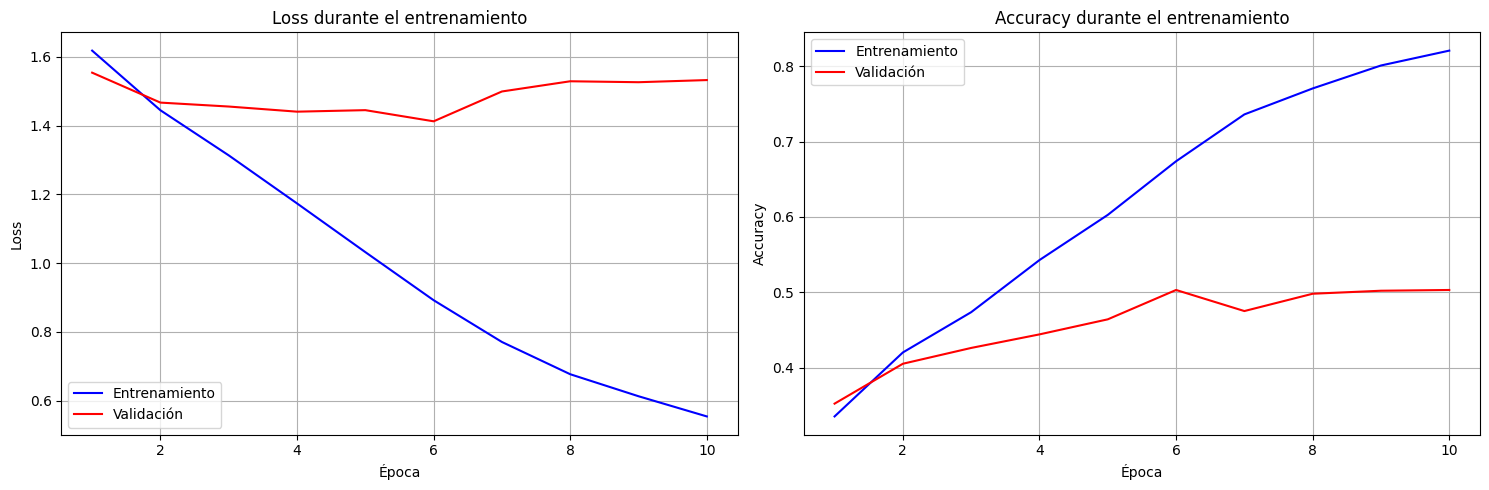

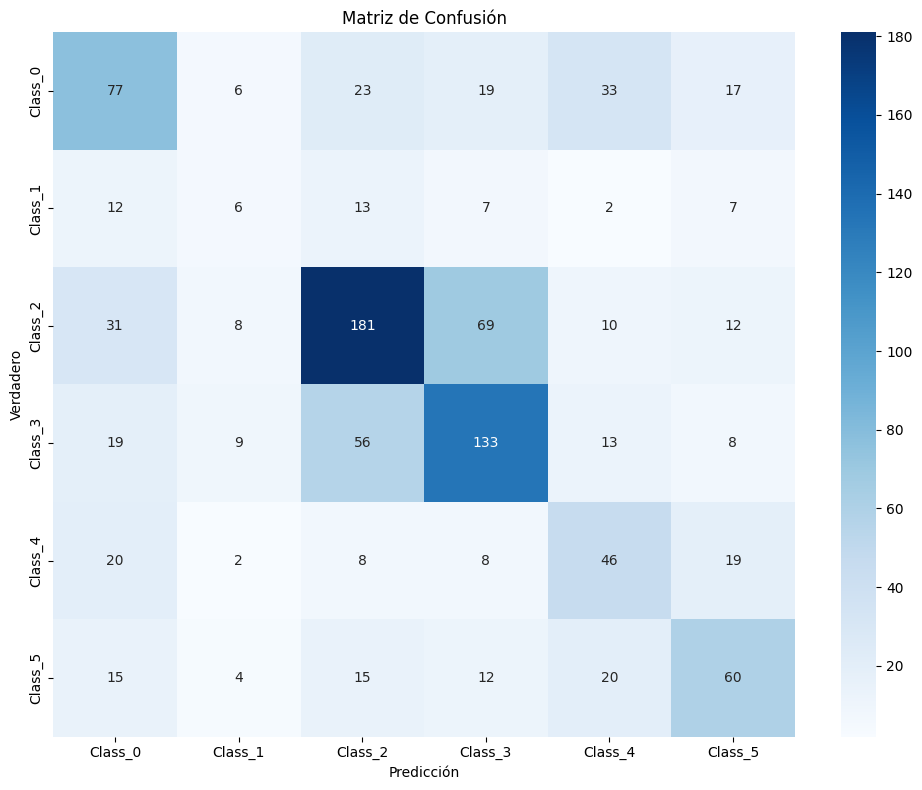

\nGuardando modelo...


2025/10/28 00:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 00:48:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/28 00:48:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'BERT_Text_Classifier' already exists. Creating a new version of this model...
2025/10/28 00:50:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_Text_Classifier, version 3
Created version '3' of model 'BERT_Text_Classifier'.


\n==================================================
RESUMEN DEL EXPERIMENTO
MLflow Run ID: 2c09bcc410224114ab1de7204f23c36f
Mejor Accuracy de Validación: 0.5030
Accuracy Final: 0.5030
Precision Final: 0.5030
Recall Final: 0.5030
F1-Score Final: 0.5023
\nArtefactos guardados:
  - Modelo: bert_classifier_model.pth
  - Gráficos de entrenamiento: training_plots.png
  - Matriz de confusión: confusion_matrix.png
  - Reporte de clasificación: classification_report.json
  - Configuración completa: experiment_config.json
🏃 View run BERT_experiment_20251027_205938 at: http://127.0.0.1:5000/#/experiments/1/runs/2c09bcc410224114ab1de7204f23c36f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
\n🎉 Experimento completado con éxito!
Revisa los resultados en MLflow UI: http://127.0.0.1:5000


In [96]:
# ENTRENAMIENTO CON MLFLOW TRACKING

import time
from tqdm.notebook import tqdm

# Iniciar el run de MLflow
with mlflow.start_run(run_name=f"BERT_experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    
    print(f"MLflow Run ID: {run.info.run_id}")
    
    # LOGGING DE CONFIGURACIÓN 
    
    # Log de hiperparámetros
    mlflow.log_params(HYPERPARAMS)
    mlflow.log_params(MODEL_CONFIG)
    mlflow.log_params(DATA_CONFIG)
    
    # Log de información del código
    mlflow.log_params(code_version)
    
    # Log de información del dataset
    mlflow.log_params(dataset_info)
    mlflow.log_param("dataset_hash", processed_data_hash)
    
    # Log del resumen del modelo
    mlflow.log_params({
        "total_parameters": model_summary['total_parameters'],
        "trainable_parameters": model_summary['trainable_parameters']
    })
    
    # Log de información del dispositivo
    mlflow.log_param("device", str(device))
    mlflow.log_param("cuda_available", torch.cuda.is_available())
    
    # ENTRENAMIENTO 
    
    # Listas para almacenar métricas de entrenamiento
    train_losses_history = []
    train_accuracies_history = []
    val_losses_history = []
    val_accuracies_history = []
    
    best_val_accuracy = 0.0
    best_model_state = None
    
    print("\\n" + "="*50)
    print("INICIANDO ENTRENAMIENTO CON MLFLOW TRACKING")
    print("="*50)
    
    for epoch in range(EPOCHS):
        print(f"\\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 30)
        start_time = time.time()
        
        # ENTRENAMIENTO 
        model.train()
        train_losses = []
        train_correct = 0
        train_total = len(df_train)
        
        train_iter = tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Train", leave=False)
        for batch in train_iter:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            
            train_correct += torch.sum(preds == labels)
            train_losses.append(loss.item())
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=HYPERPARAMS['max_grad_norm'])
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            train_iter.set_postfix(loss=np.mean(train_losses), acc=(train_correct.double() / train_total).item())
        
        train_acc = train_correct.double() / train_total
        train_loss = np.mean(train_losses)
        
        # EVALUACIÓN
        model.eval()
        test_losses = []
        test_correct = 0
        test_total = len(df_test)
        
        eval_iter = tqdm(test_data_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Eval", leave=False)
        with torch.no_grad():
            for batch in eval_iter:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs, dim=1)
                loss = loss_fn(outputs, labels)
                
                test_correct += torch.sum(preds == labels)
                test_losses.append(loss.item())
                
                eval_iter.set_postfix(loss=np.mean(test_losses), acc=(test_correct.double() / test_total).item())
        
        test_acc = test_correct.double() / test_total
        test_loss = np.mean(test_losses)
        
        # LOGGING DE MÉTRICAS POR ÉPOCA 
        
        # Almacenar métricas
        train_losses_history.append(train_loss)
        train_accuracies_history.append(train_acc.item())
        val_losses_history.append(test_loss)
        val_accuracies_history.append(test_acc.item())
        
        # Log a MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc.item(), step=epoch)
        mlflow.log_metric("val_loss", test_loss, step=epoch)
        mlflow.log_metric("val_accuracy", test_acc.item(), step=epoch)
        mlflow.log_metric("learning_rate", scheduler.get_last_lr()[0], step=epoch)
        
        # Guardar el mejor modelo
        if test_acc > best_val_accuracy:
            best_val_accuracy = test_acc.item()
            best_model_state = model.state_dict().copy()
            mlflow.log_metric("best_val_accuracy", best_val_accuracy)
        
        end_time = time.time()
        epoch_time = end_time - start_time
        
        # Log tiempo de época
        mlflow.log_metric("epoch_time", epoch_time, step=epoch)
        
        # Mostrar resultados
        print(f"Entrenamiento: Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Validación: Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
        print(f"Tiempo de época: {epoch_time:.2f} segundos")
    
    # EVALUACIÓN FINAL Y ARTEFACTOS 
    
    print("\\n" + "="*50)
    print("EVALUACIÓN FINAL Y GENERACIÓN DE ARTEFACTOS")
    print("="*50)
    
    # Cargar el mejor modelo
    model.load_state_dict(best_model_state)
    
    # Evaluación detallada
    final_metrics, predictions, true_labels, classification_rep = evaluate_model_detailed(
        model, test_data_loader, device
    )
    
    # Log de métricas finales
    mlflow.log_metrics({
        "final_accuracy": final_metrics['accuracy'],
        "final_precision": final_metrics['precision'],
        "final_recall": final_metrics['recall'],
        "final_f1_score": final_metrics['f1_score']
    })
    
    # Crear y guardar visualizaciones
    print("\\nGenerando visualizaciones...")
    
    # 1. Gráficos de entrenamiento
    training_plot_path = create_training_plots(
        train_losses_history, train_accuracies_history, 
        val_losses_history, val_accuracies_history
    )
    mlflow.log_artifact(training_plot_path)
    
    # 2. Matriz de confusión
    confusion_matrix_path, cm = create_confusion_matrix_plot(true_labels, predictions)
    mlflow.log_artifact(confusion_matrix_path)
    
    # 3. Guardar reporte de clasificación
    classification_report_path = 'classification_report.json'
    with open(classification_report_path, 'w') as f:
        json.dump(classification_rep, f, indent=2)
    mlflow.log_artifact(classification_report_path)
    
    # 4. Guardar configuración completa
    config_path = 'experiment_config.json'
    complete_config = {
        'hyperparameters': HYPERPARAMS,
        'model_config': MODEL_CONFIG,
        'data_config': DATA_CONFIG,
        'code_version': code_version,
        'dataset_info': dataset_info,
        'model_summary': model_summary,
        'final_metrics': final_metrics
    }
    
    with open(config_path, 'w') as f:
        json.dump(complete_config, f, indent=2)
    mlflow.log_artifact(config_path)
    
    # 5. Guardar el modelo
    print("\\nGuardando modelo...")
    model_path = "bert_classifier_model"
    torch.save({
        'model_state_dict': best_model_state,
        'hyperparameters': HYPERPARAMS,
        'model_config': MODEL_CONFIG,
        'tokenizer_name': PRE_TRAINED_MODEL_NAME
    }, f"{model_path}.pth")
    
    # Log del modelo en MLflow
    mlflow.log_artifact(f"{model_path}.pth")
    
    # También registrar como modelo MLflow
    mlflow.pytorch.log_model(
        model,
        "model",
        registered_model_name="BERT_Text_Classifier",
        pip_requirements=[
            f"torch=={torch.__version__}",
            f"transformers=={transformers.__version__}",
            "numpy",
            "scikit-learn"
        ]
    )
    
    # RESUMEN FINAL
    
    print("\\n" + "="*50)
    print("RESUMEN DEL EXPERIMENTO")
    print("="*50)
    print(f"MLflow Run ID: {run.info.run_id}")
    print(f"Mejor Accuracy de Validación: {best_val_accuracy:.4f}")
    print(f"Accuracy Final: {final_metrics['accuracy']:.4f}")
    print(f"Precision Final: {final_metrics['precision']:.4f}")
    print(f"Recall Final: {final_metrics['recall']:.4f}")
    print(f"F1-Score Final: {final_metrics['f1_score']:.4f}")
    print(f"\\nArtefactos guardados:")
    print(f"  - Modelo: {model_path}.pth")
    print(f"  - Gráficos de entrenamiento: {training_plot_path}")
    print(f"  - Matriz de confusión: {confusion_matrix_path}")
    print(f"  - Reporte de clasificación: {classification_report_path}")
    print(f"  - Configuración completa: {config_path}")
    
    # Tags para el experimento
    mlflow.set_tags({
        "model_type": "BERT",
        "task": "text_classification",
        "language": "multilingual",
        "framework": "pytorch",
        "status": "completed"
    })

print("\\n🎉 Experimento completado con éxito!")
print(f"Revisa los resultados en MLflow UI: {mlflow.get_tracking_uri()}")

In [ ]:
# ====== FUNCIONES DE UTILIDAD PARA MLFLOW ======

def view_experiment_results(experiment_name=None):
    """Ver resultados de experimentos en MLflow"""
    if experiment_name is None:
        experiment_name = "BERT_Text_Classification_Experiment"
    
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        print(f"No se encontró el experimento: {experiment_name}")
        return
    
    # Obtener todos los runs del experimento
    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["metrics.final_accuracy DESC"]
    )
    
    print(f"\\n=== RESULTADOS DEL EXPERIMENTO: {experiment_name} ===")
    print(f"Total de runs: {len(runs)}")
    
    if len(runs) > 0:
        # Mostrar los mejores 5 runs
        top_runs = runs.head(5)
        
        print("\\n🏆 TOP 5 MEJORES RUNS:")
        for idx, (_, run) in enumerate(top_runs.iterrows(), 1):
            print(f"\\n{idx}. Run ID: {run['run_id'][:8]}...")
            print(f"   Accuracy: {run.get('metrics.final_accuracy', 'N/A'):.4f}")
            print(f"   F1-Score: {run.get('metrics.final_f1_score', 'N/A'):.4f}")
            print(f"   Learning Rate: {run.get('params.learning_rate', 'N/A')}")
            print(f"   Batch Size: {run.get('params.batch_size', 'N/A')}")
            print(f"   Epochs: {run.get('params.epochs', 'N/A')}")
            print(f"   Dropout: {run.get('params.dropout_rate', 'N/A')}")
        
        # Mostrar estadísticas generales
        print(f"\\n📊 ESTADÍSTICAS GENERALES:")
        print(f"   Mejor Accuracy: {runs['metrics.final_accuracy'].max():.4f}")
        print(f"   Accuracy Promedio: {runs['metrics.final_accuracy'].mean():.4f}")
        print(f"   Accuracy Std: {runs['metrics.final_accuracy'].std():.4f}")
    
    return runs

def load_best_model(experiment_name=None):
    """Cargar el mejor modelo del experimento"""
    runs = view_experiment_results(experiment_name)
    
    if len(runs) > 0:
        best_run = runs.iloc[0]
        best_run_id = best_run['run_id']
        
        print(f"\\n🎯 Cargando el mejor modelo del run: {best_run_id[:8]}...")
        
        # Cargar el modelo desde MLflow
        model_uri = f"runs:/{best_run_id}/model"
        loaded_model = mlflow.pytorch.load_model(model_uri)
        
        print("✅ Modelo cargado exitosamente!")
        return loaded_model, best_run_id
    else:
        print("❌ No se encontraron runs en el experimento")
        return None, None

def compare_experiments():
    """Comparar múltiples experimentos"""
    # Esta función se puede expandir para comparar diferentes experimentos
    print("🔍 Función de comparación de experimentos disponible")
    print("Usa view_experiment_results() para ver los resultados")

def start_mlflow_ui():
    """Instrucciones para iniciar MLflow UI"""
    print("\\n🌐 Para iniciar MLflow UI, ejecuta en la terminal:")
    print("   mlflow ui")
    print("\\n   Luego abre: http://localhost:5000")
    print("\\n   Para especificar un puerto diferente:")
    print("   mlflow ui --port 5001")

# Mostrar funciones disponibles
print("\\n🛠️  FUNCIONES DE UTILIDAD DISPONIBLES:")
print("   📊 view_experiment_results() - Ver resultados de experimentos")
print("   🎯 load_best_model() - Cargar el mejor modelo")
print("   🔍 compare_experiments() - Comparar experimentos")
print("   🌐 start_mlflow_ui() - Instrucciones para MLflow UI")

# 🚀 Guía de Ejecución del Experimento con MLflow

## 📋 Pasos para ejecutar el experimento completo:

### 1. **Preparación del entorno**
```bash
# Instalar dependencias (si no están instaladas)
pip install mlflow torch transformers scikit-learn pandas openpyxl tqdm matplotlib seaborn plotly
```

### 2. **Iniciar MLflow Tracking Server (Opcional)**
```bash
# En una terminal separada, ejecutar:
mlflow ui

# O en un puerto específico:
mlflow ui --port 5000
```

### 3. **Ejecutar las celdas en orden**
- Ejecuta todas las celdas desde el inicio
- El experimento se registrará automáticamente en MLflow
- Los artefactos se guardarán automáticamente

### 4. **Monitorear el experimento**
- Abre http://localhost:5000 en tu navegador
- Ve a "Experiments" → "BERT_Text_Classification_Experiment"
- Observa métricas en tiempo real y artefactos generados

## 📊 Qué se registra automáticamente:

### ✅ **Parámetros e Hiperparámetros:**
- Learning rate, batch size, epochs, dropout rate
- Configuración del modelo y datos
- Versiones de librerías y código

### ✅ **Métricas:**
- Accuracy, precision, recall, F1-score
- Loss de entrenamiento y validación por época
- Tiempo de entrenamiento por época

### ✅ **Artefactos:**
- Modelo entrenado (.pth y MLflow model)
- Gráficos de entrenamiento
- Matriz de confusión
- Reporte de clasificación completo
- Configuración completa del experimento

### ✅ **Metadatos:**
- Hash del dataset para control de versiones
- Información del hardware (GPU/CPU)
- Timestamp del experimento
- Tags para organización

## 🎯 Optimización de Hiperparámetros

Para optimizar hiperparámetros, modifica la variable `HYPERPARAMS` en la celda de configuración:

```python
HYPERPARAMS = {
    'learning_rate': 3e-5,  # Prueba: [1e-5, 2e-5, 3e-5, 5e-5]
    'epochs': 10,           # Prueba: [3, 5, 8, 10]
    'dropout_rate': 0.2,    # Prueba: [0.1, 0.2, 0.3, 0.5]
    'batch_size': 32,       # Prueba: [8, 16, 32]
    'weight_decay': 0.01,   # Prueba: [0, 0.01, 0.1]
    # ... otros parámetros
}
```

Ejecuta múltiples experimentos con diferentes configuraciones y compara los resultados en MLflow UI.

## 📈 Visualización de Resultados

Usa las funciones de utilidad incluidas:
- `view_experiment_results()` - Ver todos los experimentos
- `load_best_model()` - Cargar el mejor modelo
- `start_mlflow_ui()` - Instrucciones para la UI